In [104]:
import tensorflow as tf
import nltk
import pandas as pd
import numpy as np
import seaborn as sn
import keras
from keras.datasets import reuters
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM,  Activation, Embedding
from sklearn.metrics import confusion_matrix
'''
    Solution Provided by :: Sayali Patkar

'''

In [2]:

'''
    Populate the pandas dataframe with reuters raw text and label for further processing

'''
(train_data, train_labels), (test_data, test_labels) = reuters.load_data()
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

print("train_data ", train_data.shape)
print("train_labels ", train_labels.shape)
print("test_data ", test_data.shape)
print("test_labels ", test_labels.shape)

train_df = pd.DataFrame(columns=['raw_text','label'])
for num in range(0,train_data.shape[0]):
    train_df = train_df.append({
     "raw_text": ' '.join([str(reverse_word_index.get(i)) for i in train_data[num]]),
     "label":  train_labels[num]
      }, ignore_index=True)

    
test_df = pd.DataFrame(columns=['raw_text','label'])    
for num in range(0,test_data.shape[0]):
    test_df = test_df.append({
     "raw_text": ' '.join([str(reverse_word_index.get(i)) for i in test_data[num]]),
     "label":  test_labels[num]
      }, ignore_index=True)

print(train_df.shape, "   ", test_df.shape)
train_df.sample(10)


train_data  (8982,)
train_labels  (8982,)
test_data  (2246,)
test_labels  (2246,)
(8982, 2)     (2246, 2)


,raw_text,label
762,the for government member be revised correctio...,4
1856,the in rights european transactions electronic...,1
8927,the repeated during one this 968 as hudson at ...,16
3006,the in airlines head said styx cts consider ca...,13
5454,the 913 outstanding was in into 8 3 there very...,19
3048,the in beyond terms 353 similar a consideratio...,20
5795,the has committee airline said in ruled surpri...,19
6117,the in union while market bought don't japanes...,8
6388,the lt they directors year reuter company barr...,3
1062,the in senate 3 market volcker contract govern...,20


In [5]:
'''
    NLP Pre-processing for the texts : numbers & stopword removal
    Since Keras provides no stropword removal, NLTK is used
    Tokenization will be done with Keras
'''
print(train_df['raw_text'][200])
stopset = stopwords.words('english')

def clean_text(doc):
    lowers = doc.lower()
    no_nums = lowers.translate(str.maketrans('','','1234567890'))
    tokens = nltk.word_tokenize(no_nums)
    filtered_tokens = [w for w in tokens if w not in stopset]
    return " ".join(filtered_tokens)

train_df['clean_text'] = train_df['raw_text'].apply(clean_text)
test_df['clean_text'] = test_df['raw_text'].apply(clean_text)
train_df.sample(10)

the payable interests services option february international and for ltd dlrs new is a dollar in 550 currency in three prepared resisted option near month at record ago a nutrition prices its in early ltd billion also is a only in going 26 3 manufacturer way mln option u prices its billion trade is for 2 11 turn dollar option operation from 250 vs produced prices its from directors vs a only 3 from brazil vs for 2 11 expansionary option a dollar j with billion also is stop and in third 550 subsidiary agriculture have only ltd expansionary arrranged said dlrs from is u agriculture a what but fault option a dollar j with dlrs new is stop and in ltd subsidiary pakistan a price 54 development 3 only have 2 peter ltd dlrs new is option february unemployment impression its company said away a investor 45 settlement a companies us need sale and in semi taking requires we in offer spokesman mln medium a investor 45 investment noranda on its for 2 11 and countries foreign vs continue from again

,raw_text,label,clean_text
3939,the ec alone profit mln at world it's for agai...,3,ec alone profit mln world 's corp strong korea...
5990,the facts american up mln 1 as imports and nat...,4,facts american mln imports nations texstyrene ...
2264,the an any had vs reuter 1985 dlrs vs some 6 i...,3,vs reuter dlrs vs includes solid intervention ...
3569,the accounts demand 31 lt joint year reuter be...,3,accounts demand lt joint year reuter year lt p...
3329,the major lt company production year reuter co...,3,major lt company production year reuter compan...
8088,the in 100 about minister mln at expressed as ...,41,minister mln expressed stimulate every said lu...
6810,the lt merger reuter company corp year an they...,3,lt merger reuter company corp year billion fee...
719,the in direct said in there 21 provided metal ...,9,direct said provided metal competitive note co...
6316,the 24 rising for 85 24 bring deep half be imp...,4,rising bring deep half implement said oppose a...
8563,the in 100 about minister mln 1 mostly for com...,4,minister mln mostly commitment completion spec...


Number of classes  46


Text(0,0.5,'Frequency')

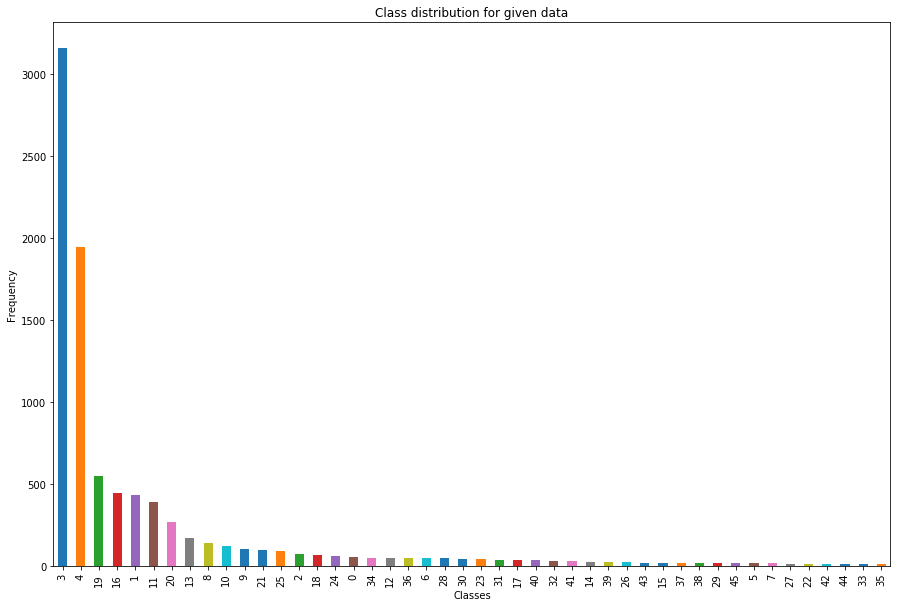

In [6]:
'''
    Data analysis and visualization

'''
print('Number of classes ',train_df['label'].unique().size)
#class distribution
plt.figure(figsize=(15,10))
train_df['label'].value_counts().plot('bar')
plt.title('Class distribution for given data')
plt.xlabel('Classes')
plt.ylabel('Frequency')

In [83]:
'''
    Classification for top 10 classes

'''
n = 10
top_classes = train_dataframe['label'].value_counts().head(n).index
df_10 = train_dataframe[train_dataframe['label'].isin(top_classes)]
df_10.sample(n)

,raw_text,label
67,the stefan agreements it ec hit through tonnes...,4
2743,the major lt revs year reuter union year major...,3
846,the airport payment twinned ingenuity polystyr...,1
6361,the lt banking year reuter from shareholders 0...,3
9,the 6 hurting up as combined months 3198 and m...,16
1919,the lt dividend year reuter dividend year 19 e...,3
3404,the in 100 k ordinary in has would three since...,19
4981,the lt any year reuter 1985 year an sullivan o...,3
2191,the for japan full industry machines 846 offic...,4
1020,the in 100 k ordinary in has would three since...,19


In [8]:
'''
    Identifying top n classes and preparing data inputs to Neural Network

'''
n = 10
top_classes = train_df['label'].value_counts().head(n).index
print("Top 10 classes :: ",top_classes)
train_df_10 = train_df[train_df['label'].isin(top_classes)]
test_df_10 = test_df[test_df['label'].isin(top_classes)]

#Validation split
val_df_10=train_df_10.sample(frac=0.2,random_state=200)
train_df_10=train_df_10.drop(val_df_10.index)
print("\nAfter the splits we have :: ")
print("%s taining samples, %s validation samples and %s test samples."%(len(train_df_10), len(val_df_10), len(test_df_10)))

#update the labels to get right num of catagories after to_categorical() conversion
for num in range (0,10):
    train_df_10.loc[train_df_10['label'] == top_classes[num], 'updated_label'] = num
    test_df_10.loc[test_df_10['label'] == top_classes[num], 'updated_label'] = num
    val_df_10.loc[val_df_10['label'] == top_classes[num], 'updated_label'] = num

#print(val_df_10.sample(20))

texts=train_df_10.clean_text
TOP_WORDS = 10000
tokenizer = Tokenizer(num_words=TOP_WORDS)
tokenizer.fit_on_texts(texts)

sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid=tokenizer.texts_to_sequences(val_df_10.clean_text)
sequences_test=tokenizer.texts_to_sequences(test_df_10.clean_text)

word_index = tokenizer.word_index
print("\nFound %s unique tokens." % len(word_index))

#For the sake of simplicity of implementation, keras only accepts sequences of the same length in a batch.
X_train = pad_sequences(sequences_train)
MAX_LEN = X_train.shape[1]
X_val = pad_sequences(sequences_valid, maxlen = MAX_LEN)
X_test = pad_sequences(sequences_test, maxlen = MAX_LEN)

#One hot catagorical representation for relavance with final softmax output
y_train = to_categorical(np.asarray(train_df_10.updated_label))
y_val = to_categorical(np.asarray(val_df_10.updated_label))
y_test = to_categorical(np.asarray(test_df_10.updated_label))

print("Shape of X train, X validation and X test ::", X_train.shape,X_val.shape,X_test.shape)
print("Shape of label train, validation and test ::", y_train.shape,y_val.shape,y_test.shape)


Top 10 classes ::  Int64Index([3, 4, 19, 16, 1, 11, 20, 13, 8, 10], dtype='int64')

After the splits we have :: 
6102 taining samples, 1525 validation samples and 1882 test samples.


c:\users\sarap\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\sarap\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



Found 20347 unique tokens.
Shape of X train, X validation and X test :: (6102, 1567) (1525, 1567) (1882, 1567)
Shape of label train, validation and test :: (6102, 10) (1525, 10) (1882, 10)


In [13]:
'''
    Building RNN(LSTM) model and predicting

'''
EMB_LEN = 50
# define the LSTM model
model = Sequential()
#embedding layer added to match 3D LSTM input
model.add(Embedding(TOP_WORDS, EMB_LEN, input_length=MAX_LEN))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit training data, validation helps for stopping criteria
plot_data = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=100)
# list all data in history
print(plot_data.history.keys())

Train on 6102 samples, validate on 1525 samples
Epoch 1/10
6102/6102 [==============================] - 198s 32ms/step - loss: 1.6636 - acc: 0.4310 - val_loss: 1.3275 - val_acc: 0.4964
Epoch 2/10
6102/6102 [==============================] - 199s 33ms/step - loss: 1.0959 - acc: 0.6164 - val_loss: 1.1249 - val_acc: 0.6210
Epoch 3/10
6102/6102 [==============================] - 192s 31ms/step - loss: 0.9512 - acc: 0.6609 - val_loss: 1.0895 - val_acc: 0.6387
Epoch 4/10
6102/6102 [==============================] - 184s 30ms/step - loss: 0.9110 - acc: 0.6829 - val_loss: 1.0761 - val_acc: 0.6505
Epoch 5/10
6102/6102 [==============================] - 186s 30ms/step - loss: 0.8235 - acc: 0.7248 - val_loss: 1.1635 - val_acc: 0.6334
Epoch 6/10
6102/6102 [==============================] - 186s 30ms/step - loss: 0.7405 - acc: 0.7584 - val_loss: 1.0175 - val_acc: 0.6833
Epoch 7/10
6102/6102 [==============================] - 183s 30ms/step - loss: 0.6400 - acc: 0.7935 - val_loss: 1.0430 - val_acc: 

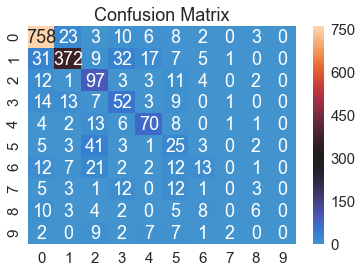

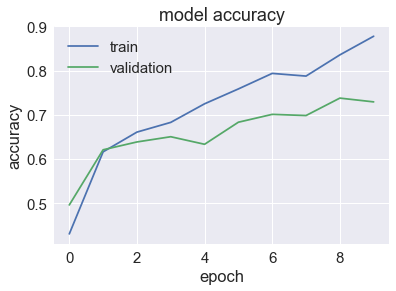

In [37]:
'''
   Analyzing the results

'''
y_pred = model.predict(X_test)

# Creating the Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# confusion matrix plot
df_cm = pd.DataFrame(cm, range(10),range(10))
sn.set(font_scale=1.5)#for label size
sn.heatmap(df_cm, annot=True, center=300, fmt='g').set_title('Confusion Matrix')
plt.show()

# accuracy plot
plt.plot(plot_data.history['acc'])
plt.plot(plot_data.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

c:\users\sarap\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


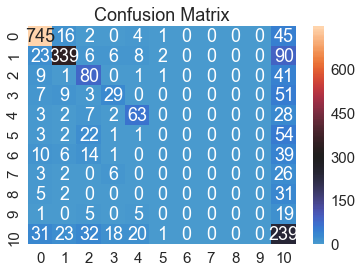

In [84]:
'''
    Predicting for open set problem approach : by extending pretrained model
    Using the predicted softmax output for determining how 'confident' the classifier is in prediction
    for example for a 3 catagory classification, classifier predicts class 0 in the following 2 sensios
    senario1 = [0.6, 0.2, 0.2]
    senario2 = [0.42, 0.38, 0.20]
    in case of senario1, class 0 is easy win but for senario2 classifier is not as confidant about class 0 prediction.
    Instead one can make it open set problem in which one adds fourth 'unknown' class and our previous senarios will now be
    senario1 = [0.6, 0.2, 0.2, 0.0]
    senario2 = [0.0, 0.0, 0.0, 1]
    The criteria for determining optimum confidence obvious must be decided after through study of classification results
'''
#pred_sorted = np.sort(y_pred, axis = 1)
#pred_sorted = pred_sorted[:,9]-pred_sorted[:,8]

#lets assume min confidance difference should be 0.5
min_conf_dif = 0.5

'''
    Preparing test set to observe detection/rejection performance

'''

#Adding all other classes in test set as 11 th class
test_df_11 = test_df[~test_df['label'].isin(top_classes)]
test_df_11['updated_label'] = 10
frames = [test_df_10, test_df_11]
test_df_new = pd.concat(frames)

sequences_test_new=tokenizer.texts_to_sequences(test_df_new.clean_text)
X_test_new = pad_sequences(sequences_test_new, maxlen = MAX_LEN)

#One hot catagorical representation for relavance with final softmax output
y_test_new = to_categorical(np.asarray(test_df_new.updated_label))

'''
    Predicting on new test set using alredy trained model and adding 'unknown' catagory to output :: y_pred_new_updated

'''
y_pred_new =  model.predict(X_test_new)
y_pred_new_updated =np.zeros([y_pred_new.shape[0],11], dtype=np.float64)
for num in range(0,y_pred_new.shape[0]):
    row = np.sort(y_pred_new[num,:])[::-1]
    if(row[0]-row[1]>min_conf_dif):
        row = np.append(y_pred_new[num,:],0)
    else:
        row = np.append(np.zeros(10),1)
    y_pred_new_updated[num,:] = row    
    
cm = confusion_matrix(y_test_new.argmax(axis=1), y_pred_new_updated.argmax(axis=1))

# confusion matrix plot
df_cm = pd.DataFrame(cm, range(11),range(11))
sn.set(font_scale=1.5)#for label size
sn.heatmap(df_cm, annot=True, center=300, fmt='g').set_title('Confusion Matrix')
plt.show()

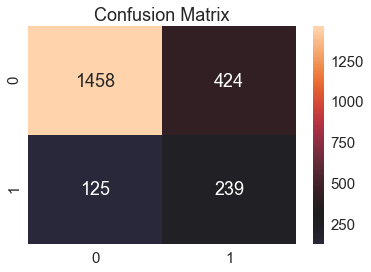

In [102]:
'''
    Detection/Rejection Performance
'''
# here 0 for detection and 1 for rejection
y_test_bin = (y_test_new.argmax(axis=1)==10).astype(int)
test_total = sum(y_test_bin==1)
y_pred_bin = (y_pred_new_updated.argmax(axis=1)==10).astype(int)
pred_total = sum(y_pred_bin)
cm = confusion_matrix(y_test_bin, y_pred_bin)

# confusion matrix plot
df_cm = pd.DataFrame(cm, range(2),range(2))
sn.set(font_scale=1.5)#for label size
sn.heatmap(df_cm, annot=True, center=300, fmt='g').set_title('Confusion Matrix')
plt.show()

In [103]:
print("1458 samples detected correctly, 239 rejected correctly and 549 samples were mispaced")
detection_precision = 1458/(1458+125)
print("Detection Precision :: ",detection_precision)
rejection_precision = 239/(239+424)
print("Rejection Precision :: ",rejection_precision)

1458 samples detected correctly, 239 rejected correctly and 549 samples were mispaced
Detection Precision ::  0.9210360075805433
Rejection Precision ::  0.36048265460030166
